При выполнении данного задания вы познакомитесь с рядом базовых подходов к градиентной оптимизации, такими как Basic Diffirential Multiplier Method (метод Лагранжа), Penalty method (метод штрафов) и их комбинацией -- Modified Differential Method of Multipliers. Также будет четко обозначено, как можно добиться максимизации функции (а не минимизации). Будут разобраны эвристики, позволяющие применять эти методы для задач, в которых присутствуют не только ограничения, выраженные равенствами, но и неравенствами.

Также вы получите опыт работы с PyTorch, вы познакомитесь с рядом базовых компонент данной библиотеки, получите представление о том, что данный фреймворк может использоваться не только для задач машинного обучения, но и для решения более нестандартных проблем.

---

# Градиентный спуск

Наверное, ни для кого не будет новостью, что градиент, или вектор первых производных функции, определяет направление ее наискорейшего роста. Сразу же напрашивается очевидный вывод: если мы в данной точке пространства вычислим антиградиент (градиент * (-1)) данной функции, и прибавим его к координатам данной точки, мы сместимся на позицию, лежащую ближе к точке минимума этой функции. И, если мы снова и снова будем повторять все те же действия, рано или поздно мы сойдемся к этой точке минимума. Гипотетически, наверное любую задачу оптимизации можно свести к данной формулировке, и решить его методом градиентного спуска. На практике, поверхность целевой функции может быть достаточно сложной, и решать данную задачу "в лоб" можно очень и очень долго (и результат не гарантирован).

![GD](https://storage.ning.com/topology/rest/1.0/file/get/3713179836?profile=RESIZE_710x)

Для ускорения процесса и улучшения качества сходимости (мы хотим, по возможности, найти самую "глубокую" точку из локальных минимумов, в идеале, достичь минимума глобального) придумано множество подходов. Большая часть из хорошо работающих идей реализована в библиотеках для машинного обучения:

- Tensorflow, Keras
- PyTorch
- Theano
- Vowpal Wabbit
- Caffe
- FastAI
- etc.

---

# PyTorch

Pytorch является, на мой обывательский вкус, одной из лучших библиотек для машинного обучения (и, как мы увидим, не только). Перечислять преимущества по сравнению с другими продуктами можно очень долго, в интернете много написано по данному вопросу. Назову два важнейших аспекта данной библиотеки:

- Относительная простота использования
- Достаточная гибкость, которая позволяет решать задачи, к машинному обучению относящиеся сравнительно косвенно

Зачем вообще эти ваши торчи, почему нельзя с нуля все написать

- В PyTorch встроена функция автоматического дифференцирования, о которой более подробно расскажу ниже. А, говоря в общем, нам не нужно реализовать какие-то свои функции взятия производных, использовать сторонние библиотеки, или находить их аналитичеcки, а потом явным образом прописывать в коде.

- В PyTorch уже реализованы компоненты, позволяющие задать алгоритм градиентного спуска для соответствующей задачи буквально в нескольких строчках кода.

---

# Подробнее о компонентах PyTorch, которые мы будем использовать
**Disclaimer: понимание этого абзаца ни в коем мере не повлияет на выполнение задания, он скорее добавляет контекста, чтобы было понятно, что именно из PyTorch я использую, и почему**
#### Модель:

Еще раз, Pytorch предназначен для задач машинного обучения, и этот примитив используется для создания моделей (функций), описывающих закономерности в данных. 
Приведу пример одной из таких задач: 

Предположим, у нас есть табличка, в которой собраны рост, вес и возрат некоторого числа людей. И мы хотели бы узнать, каким образом рост и вес связаны с возрастом. Предполагая, что взаимосвязь можно задать функционально, мы ставим себе задачу, найти такую функцию, которая, принимая на вход два числа (рост и вес) должна в качестве результата давать одно число -- возраст. Естественно, нам бы хотелось, чтобы результат соответствовал истине.

Вырисовывается примерный план действий: мы должны сделать несколько попыток "подобрать" реальную функцию, при этом после каждой попытки надо оценить результат (насколько похожи ответы модели на реальные данные, насколько возраст, который нам сообщила модель, соответсвует реальному возрасту конкретного человека). После оценки качества модели, в соответствии с полученными результатами, мы должны или скорректировать нашу подбираемую функцию, чтобы добиться более качественного результата, либо, если результат нас удовлетворил, на этом остановиться.

**Как же реализовать этот процесс?**

Наш великий соотечественник, советский математик А. Н. Колмогоров доказал теорему, из которой следует, что любую функцию можно аппроксимировать многослойным перцептроном (MLP).

**Что такое MLP?**

Да по сути очень простая вещь, если не углубляться в абстракции и не рисовать красивые картиночки с кружочками, соединенными отрезками. 

Вот, допустим у нас есть матричка признаков X, и мы хотим получить результат -- вектор Y (вектор Y не обязательно тот самый который мы ищем, здесь это просто ответы произвольного MLP, когда мы подаем ему на вход признаки Х)
Для этого мы будем домножать n раз Х на матрички W_i, и на каждом шаге, кроме последнего к произведению будем применять какую-то нелинейную функцию (или - функцию активации, а, кстати, элементы матричек зовутся нейронами)
Например для n = 3 (трехслойный MLP) это будет выглядеть так:
$$Y = W_3\times(\phi(W_2\times\phi(W_1\times X)))$$
Почему я выбрал n равным именно 3? На практике, такой сложности нейросети (MLP -- один из базовых видов нейросетей) хватит, для того, чтобы аппроксимировать функцию любой сложности.
Предвосхищу так же возможно возникшее недопонимание: эти матрицы могут быть какими угодно, и это тоже будет MLP, но мы хотим задать их так, и соответственно задать и перцептрон так, чтобы результат функции удовлетворял каким то условиям, соответствовал неким критериям

Вернемся к процессу выучивания функции:
Еще раз, когда мы хотим выучивать зависимость между $X$ и $Y_{target}$, нам надо соответствущим образом настроить наш MLP, так, чтобы $Y_{target} \approx Y = MLP(X)$.

**Для этого нам надо решить, как делать две вещи:**

1. Как оценивать качество модели:
Логично предположить, что каждое число, каждый элемент вектора $Y$ должен быть максимально похожим на соответствующий ему элемент вектора $Y_{target}$
А давайте просто возьмем разницу между предсказанным элементом и целевым элементом, возведем в квадрат, а потом усредним? Получится среднеквадратичная ошибка MSE:
$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i - y_i^{target})^2$$
Почему берем в квадрат, а не модуль находим? Ну, во 1-х модуль не везде дифференцируем, а мы бы хотели (вернемся к этому чуть позже), чтобы наша мера ошибки была дифференцируема, во вторых, у такой меры ошибки есть несколько полезных статистических свойств, освещать их подробно не буду, тоже все в интернете есть.

2. Как нам менять наш MLP, чтобы результат преобразования MLP(X) наилучшим образом соответствовал реальным значениям?
Вообще говоря, у MLP есть две группы параметров: функции активации $\phi(.)$ и набор матричек $W_i$
Выбор функции активации, в общем то, на результат прямого влияния не оказывает, а выбирать их можно руководствуясь здравым смыслом и опытом, и, снова, это могла бы быть тема для отдельной статьи. В данной ситуации предположим, что нам бы подошла любая нелинейная дифференцируемая функция, определенная на вещественной прямой. А вот выбор матричек $W_i$ уже куда более важен.
Мы можем сказать, что каждая из матриц $W_i$ это матрица, состоящая из $n\times m$ переменных $w_{i, j, k}$. 
И если бы мы совсем двинулись, и расписали MSE, как функцию от $w_{i,j,k}$, да взяли бы частную производную по каждой $w_{i,j, k }$, мы получили бы градиенты для каждой матрицы, и смогли бы изменить эти матрицы так, чтобы функция MSE для данных $Y_{target}$ и $Y=MLP(X)$ уменьшилась. Повторяем несколько раз, и задача будет решена. Если же мы рациональные люди, мы используем одну из библиотек машинного обучения, типа PyTorch, в которой все эти процедуры автоматизированы умными людьми и сделано это оптимальным образом.
---
Как нам задать такую модель? 
Пример в ячейке ниже



*Немного про классы и наследования:
Не буду рассказывать зачем и для чего это нужно, поскольку тема эта достаточно обширная, но все же хотел уточнить аспекты, которые нужны именно нам, для тех кто еще не знаком с классами. Класс это "конструктор", с заранее определенным функционалом. Также, внутри класса могут быть заданы свои переменные, могут храниться данные, к которым мы не можем обратиться произвольным образом в других частях программы.* 

*Поясню на примере ячейки ниже: в классе MLP содержится переменная self.layers. self. -- обязательная приставка для переменных, которые мы бы возможно захотели использовать в других методах (например def forward) данного класса. За пределами класса тоже можно обращаться к этим переменным. Если мы создадим экземпляр класса model = MLP()-- объект, созданный, в соответствии с конструкцией, которую мы задали, написав класс, то создастся и соответсвующая данному объекту переменная layers, и, чтобы было понятно, что мы хотим обратиться к переменной соответствующего класса, нужно написать model.layers*

*Про наследование: мы можем при задании класса сослаться на какой-то объект, написанный когда-то кем-то, или написанный нами ранее. Тогда при использовании объектов класса-наследника мы можем использовать функционал и переменные, если они есть класса-родителя. В ячейке ниже мы наследуемся от класса nn.Module*

In [ ]:
#импортируем необходимые библиотеки
import torch
from torch import nn, optim
import numpy as np

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100), #матричка W_1 размера nxm
            nn.ReLU(), #функция активации ф(.)
            nn.Linear(100, 1) #еще одна матричка, W_2 размера mxn
        )
        
    def forward(self, x): #процесс вычисления Y = MLP(X), последовательно (мы матрицы и функцию активации положили в
        x = self.layers(x) #nn.Sequential), к нашим признакам X будут применяться соответствующие преобразования с использованием
        return x # матриц W_i и функции активации

Как будет выглядеть процесс обучения, а так же подробнее об остальных компонентах PyTorch, которые мы будем использовать (оптимизатор и функция ошибки):

In [ ]:
model = MLP()#создаем модель
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)#задаем оптимизатор, который будет изменять матрицы, улучшая модель
#при его инициализации мы передаем ему параметры модели (матрицы W_i) и задаем параметр lr -- learning rate = 10^(-3)
#На этот параметр lr будет домножаться градиент для улучшения качества сходимости
loss_fn = nn.MSELoss()#думаю, тут комментарии излишни

In [ ]:
X = torch.from_numpy(np.linspace(0, 3, 100)).type(torch.FloatTensor).view(-1, 1)
target = torch.from_numpy(np.sin(np.linspace(0, 3, 100))).type(torch.FloatTensor).view(-1, 1) #наши данные

In [ ]:
#стандартный пайплайн градиентной оптимизации
for i in range(5000):
  optimizer.zero_grad()#зануляем градиенты, полученные на предыдущем шаге, по идее, надо писать в конце, но часто про это забывают
  y = model(X) #вычисляем значение MLP
  loss = loss_fn(y, target)#вычисляем среднеквадратичную ошибку
  loss.backward()#вычисляем градиенты
  optimizer.step()#выполняем шаг градиентного спуска, на -1 домножать не надо, это уже зашито в систему
  #на всякий случай уточню, в простейшем случае строчка optimizer.step() изменяет параметры модели (w), вычисляя следующее выражение
  #w = w - lr * grad(...), в более продвинутых в эту формулу могут включатся моментум (ускорение) и другие добавки, позволяющие
  #ускорить процесс сходимости и улучшить его качество

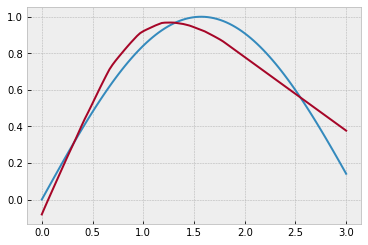

In [ ]:
plt.plot(X.numpy(), target.numpy())
plt.plot(X.numpy(), model(X).detach().numpy())
plt.plot()

Если увеличить число итераций, графики совпадут

# Градиентная оптимизация заданной функции

Давайте немного обобщим задачу, обсуждаемую ранее: 
Мы минимизировали $MSE$, выполняя градиентный спуск по переменным $w_{i, j, k}$.

А что, если мы попробуем минимизировать произвольную функцию $f(x)$? Можно добиться столь же хорошего результата, выполняя градиентный спуск по переменной $x$

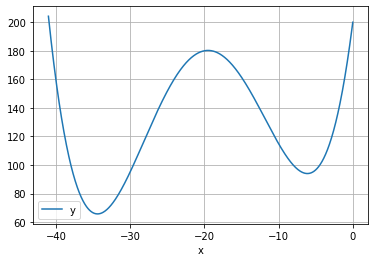

In [ ]:
def f(x):
  return (0.05 * x**2 + 2 * x + 10)**2 + 100 + x

import pandas as pd

pd.DataFrame(
    {
        'x' : np.linspace(-41, 0, 1000),
        'y': f(np.linspace(-41, 0, 1000))
    }
).plot(x='x', y='y', grid=True)

Вместо nn.MSELoss() нам надо написать свою функцию, которую мы будем минимизировать. Для этого нужно написать класс, наследующийся от модуля nn.Module

In [ ]:
class X2_loss(nn.Module):

  def __init__(self):
      super(X2_loss, self).__init__()
      
  def forward(self, x):
      result = (0.05 * x**2 + 2 * x + 10)**2 + 100 + x
      return result

А теперь создадим модель, которая будет выполнять функции нашей переменной. Никаких секвеншиалов не надо, она просто возвращает свой единственный параметр, у которого будет реализована возможность вычисления градиента (делается автоматически при инициализации как nn.Parameter()

In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super().__init__()
        w = torch.tensor([1.])
        self.w = nn.Parameter(w)        
        
    def forward(self):
        return self.w

А дальше -- ничего нового.

In [ ]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.90)#параметр моментум моделирует ускорение,
                                                                #можно представить себе шарик, скатывающийся по склону,
                                                                #если он наберет большое ускорение, то он, минуя мелкие впадины
                                                                #достигнет минимума
loss_fn = X2_loss()
for i in range(15000):
   optimizer.zero_grad()
   output = model()
   loss = loss_fn(output)
   loss.backward()
   optimizer.step()

In [ ]:
model.w.detach().numpy().item()

-34.38580322265625

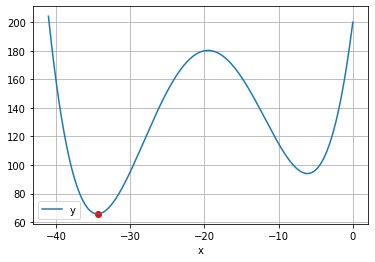

In [ ]:
from matplotlib import pyplot as plt
pd.DataFrame(
    {
        'x' : np.linspace(-41, 0, 1000),
        'y': f(np.linspace(-41, 0, 1000)),
        
    }
).plot(x='x', grid=True)
plt.scatter(x=model.w.detach().numpy().item(), y=f(model.w.detach().numpy().item()), c='r')
plt.show()

Давайте немного усложним задачу, пусть будет несколько переменных, и добавятся ограничения
Рассмотрим следующую задачу:
$$y^2+x^2\rightarrow min$$
$$s.t.$$
$$ x+y = 1$$
Чтобы решить эту задачу нужно слегка изменить подход, который мы использовали ранее.
Нашу целевую функцию необходимо будет подменить на Лагранжиан, с которым вы все уже, безусловно знакомы, для того чтобы учесть при решении ограничения. 

Напомню, что когда вы решаете задачу методом Лагранжа вы аналитически находите значения всех переменных, как целевых, так и множителей Лагранжа. То есть, абы какие коэффициенты лямбда использовать не получится. Как же нам их оценить? Решение очень простое: будем выполнять градиентную оптимизацию и для лямбд тоже. 
Один важный нюанс: авторы статьи [Constrained Differential Optimization for Neural Networks](https://www.researchgate.net/publication/36713153_Constrained_Differential_Optimization_for_Neural_Networks) (1988) доказали, что, если мы будем выполнять градиентный спуск на все переменные, метод не сойдется. К счастью, они же предложили решение: в то время, как мы будем выполнять градиентный спуск на x и y, мы будем выполнять градиентный **подъем** на параметры $\lambda$.

In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([1.])) 
        self.y = nn.Parameter(torch.tensor([1.])) 
        self.lambdas = nn.Parameter(torch.tensor([1.]))
              
        
    def forward(self):
        return self.x, self.y, self.lambdas

In [ ]:
class func_loss(nn.Module):
  def __init__(self):
      super(func_loss, self).__init__()
      
  def forward(self, x, y, lambdas):
      result = (x**2 + y**2) + lambdas * (x + y - 1)
      return result

In [ ]:
model = Model()
loss_fn = func_loss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)#опять другой оптимизатор, адам -- один из лучших оптимизаторов, когда 
objectives = []                                    #у вас нет своего мнения по вопросу, какой оптимизатор для данной задачи лучше
losses = []                                        #lr = 1e-3 выбран по тому же принципу, дает хорошее начальное приближение,
for i in range(6000):                              #дальше можно его менять
  optimizer.zero_grad()
  x, y, lambdas = model()
  loss = loss_fn(x, y, lambdas)
  obj = loss_fn(model.x.detach(), model.y.detach(), torch.tensor([0.0]))
  objectives.append(obj.numpy()[0])
  losses.append(loss.item())
  loss.backward()
  model.lambdas.grad = - model.lambdas.grad #делаю градиентный подъем по лямбдам
  optimizer.step()

Вот как изменяется значение Лагранжиана с течением времени, и как изменяется значение целевой функции

Видно, что в конечном счете они стабилизировались

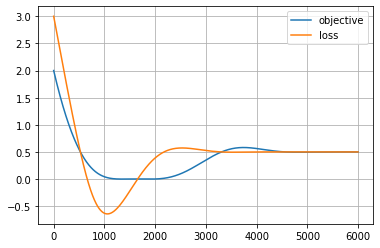

In [ ]:
import pandas as pd

pd.DataFrame(
    {'objective': objectives,
    'loss': losses}
).plot(grid=True)

Усложним задачу еще сильнее:
$$-2x_1+x_2+6x_3+3\rightarrow max$$
$$s.t.$$
$$x_1-3x_2+2x_3=1$$
$$-2x_1+4x_2+x\leq -7$$
$$-x_1+x_2+4x_3\geq6$$
$$\forall x_i>=0$$

Что изменилось? 
- Во-первых, выросло количество и переменных, и ограничений, поэтому с вашего позволения, для лаконичности и масштабируемости кода я буду выполнять вычисления в матричном виде.
- Во-вторых, появились неравенства.
Как же с ними работать?
Авторы все той же статьи предложили следующий вариант:
Если мы имеем ограничение $h(x)>=0$, то можно переписать его в виде:
$$g(x) = h(x) - z^2 = 0$$
Если мы будем выполнять градиентный спуск еще и на z (в статье называется slack variable), то, поскольку член z^2 всегда положителен, исходное неравенство всегда выполнится.
-  В-третьих перед нами стоит задача максимизации: чтобы ее решить, лосс-функция должна выглядеть не как $L(x) = obj(x) + Lagrangian(x)$, а как $L(x) = - obj(x) + Lagrangian(x)$

В данном задании уже достаточно много переменных, много ограничений, поэтому для улучшения сходимости (скорости работы и качества) алгоритма добавим штрафную компоненту 
$$L(x) = -obj(x) + Lagrangian(x) + C\cdot\sum(g(x))^2$$

Т.е. мы как бы штрафуем нашу модель за отклонения от ограничений: она хочет минимизировать все выражение, но если она нарушает ограничения, мы увеличиваем его причем размер этого штрафа квадратично пропорционален отклонению.

In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([1., 1., 1.]))  
        self.lambdas = nn.Parameter(torch.tensor([1.]*6))
        self.z = nn.Parameter(torch.tensor([1.]*5))
 
    def forward(self):
        return self.x, self.lambdas, self.z

class func_loss_maximize_w_pen(nn.Module):

  def __init__(self):
      super(func_loss_maximize_w_pen, self).__init__()
      
  def forward(self, x, lambdas, z):
      c = 10
      coefs = torch.tensor([-2.0, 1.0, 6.0])
      obj = torch.sum(x * coefs) + 3
      const_1_coefs = torch.tensor([1., -3., 2.])
      const_2_coefs = torch.tensor([2., -4., -1.])
      const_3_coefs = torch.tensor([-1., 1., 4.])
      const_1 = torch.sum(const_1_coefs * x) - 1
      const_2 = torch.sum(const_2_coefs * x) - 7 - z[0]**2
      const_3 = torch.sum(const_3_coefs * x) - 6 - z[1]**2
      const_4 = torch.sum(lambdas[3:] * (x - z[2:]**2))
      result = -obj + lambdas[0]*const_1 + lambdas[1] * const_2 + lambdas[2] * const_3 + const_4
      result = result + c * (const_1**2 + const_2**2 + const_3**2 + torch.sum((x - z[2:]**2))**2)
      return result

In [ ]:
model = Model()
loss_fn = func_loss_maximize_w_pen()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
objectives = []
losses = []
x_series = []
bounds = []

In [ ]:
for i in range(150000):
  optimizer.zero_grad()
  x, lambdas, z = model()
  x_series.append([a.item() for a in x.detach().numpy()])
  loss = loss_fn(x, lambdas, z)
  obj = loss_fn(model.x, torch.tensor([0.0]*6), z)
  objectives.append(obj.detach().numpy().item())
  losses.append(loss.item())
  loss.backward()
  xs = model.x.detach().numpy()
  xs = np.array([x.item() for x in xs])
  bounds.append([np.sum(xs * np.array([1., -3., 2.])) -1, np.sum(xs * np.array([2., -4., -1.])) -7, np.sum(xs * np.array([-1., 1., 4.])) -6])
  model.lambdas.grad = - model.lambdas.grad
  optimizer.step()

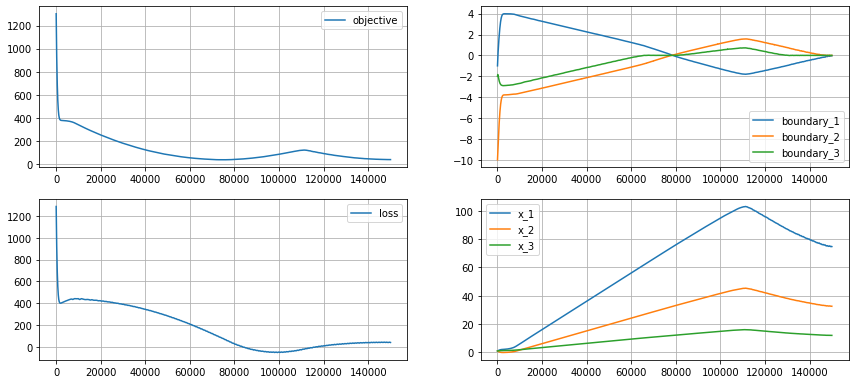

In [ ]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14.5, 6.5)
pd.DataFrame({'objective':objectives}).plot(grid=True, ax=ax[0][0])
pd.DataFrame({'loss':losses}).plot(grid=True, ax=ax[1][0])
pd.DataFrame(bounds).rename(columns={0:'boundary_1', 1:'boundary_2', 2:'boundary_3'}).plot(grid=True, ax=ax[0][1])
pd.DataFrame(x_series).rename(columns={0:'x_1', 1:'x_2', 2:'x_3'}).plot(grid=True, ax=ax[1][1])
plt.show()

Комментарий по поводу правого верхнего графика, остальные, думаю, говорят сами за себя. На этом графике изображено изменение значения ограничений (каждого из тех трех, которые не так тривиальны, как $x_i\geq0$. Видно, что под конец они сошлись к нулю.

Можете сравнить с решением в Вольфраме

In [ ]:
print('args:', *[x.item() for x in model.x.detach().numpy()])
print('result:', objectives[-1])

args: 74.80170440673828 32.640743255615234 12.039931297302246
result: 41.74041748046875


Теперь давайте решим какую-нибудь экономическую задачку.

Рассмотрим модель рынка труда в условиях совершенной информации.
Предположим, вы производитель, и ваша выручка Y(x) зависит от количества времени, которое трудились ваши работники. Для простоты пусть Y(x) = x

Пусть на рынке есть два типа агентов, поровну каждого типа, $$\mu_1 = \mu_2 = \frac{1}{2}$$

Функция издержек работника типа 1: $C_1(x_1) = 0.5 x_1^2$

Второго типа: $C_2(x_2) = x_2^2$

Запишем задачу производителя:
$$\Pi = \mu_1(x_1 - w_1) + \mu_2(x_2-w_2)\rightarrow max$$
где  $w_1$, $w_2$ -- выплаты работнику каждого типа

При ограничениях: 

Individual Rationality Constraints
$$\forall i: w_i - C_i(x_i)\geq0$$ 
Positivity constraints
$$\forall i: w_i\geq0, x_i\geq0$$


In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([1e-25, 1e-25]))
        self.w = nn.Parameter(torch.tensor([1e-25, 1e-25])) 
        self.lambdas = nn.Parameter(torch.tensor([[1e-25, 1e-25] for i in range(3)]))
        self.z = nn.Parameter(torch.tensor([[1e-25, 1e-25] for i in range(2)]))       
        
    def forward(self):
        return self.x, self.w, self.lambdas, self.z

In [ ]:
def agent_1(x):
  return 0.5 * x**2
def agent_2(x):
  return x**2


class LagrangeLoss(nn.Module):
  def __init__(self, agents, mus):
    super(LagrangeLoss, self).__init__()
    self.mus = mus
    self.agents = agents
  
  def apply_cost_function(self, x):
    result = torch.zeros(x.shape)
    for i, agent in enumerate(self.agents):
      result = result + agent(x) * torch.tensor([1.0 if j==i else 0.0 for j in range(x.shape[0])])
    return result

  def calc_IR(self, x, w):
    result = w - self.apply_cost_function(x)
    return result

  def forward(self, x, w, lambdas, z):
    revenue = torch.sum(self.mus * (x - w))   
    IR_const = torch.sum(lambdas[0] * self.calc_IR(x, w))
    pos_x_const = torch.sum(lambdas[1] * (x - z[0]**2))
    pos_w_const = torch.sum(lambdas[2] * (w - z[1]**2))
    return - revenue + IR_const + pos_x_const + pos_w_const 

In [ ]:
model = Model()
loss_fn = LagrangeLoss([agent_1, agent_2], torch.tensor([1/2, 1/2]))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
w_history, x_history, loss_history = [], [], []

In [ ]:
for i in range(50000):
  #Вот эти условия ниже нужны для более быстрой сходимости: чем больше lr, тем выше скорость, но меньше точность
  if i>=20000 and i<=35000:
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
  if i >35000:
    optimizer = optim.Adam(model.parameters(), lr=1e-6)
  optimizer.zero_grad()
  x, w, lambdas, z = model()
  loss = loss_fn(x, w, lambdas, z)
  loss_history.append(loss.item())
  x_history.append([el.item() for el in model.x.detach().numpy()])
  w_history.append([el.item() for el in model.w.detach().numpy()])
  loss.backward()
  model.lambdas.grad = - model.lambdas.grad
  optimizer.step()


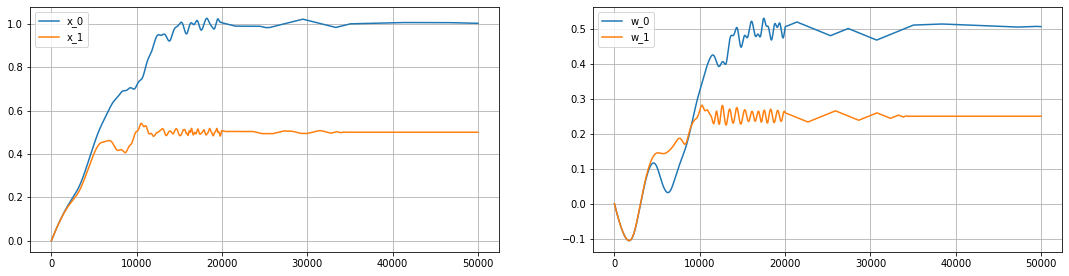

In [ ]:
X = pd.DataFrame(x_history)
W = pd.DataFrame(w_history)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18.5, 4.5)
X.rename(columns={0:'x_0', 1:'x_1'}).plot(ax=ax[0], grid=True) 
W.rename(columns={0:'w_0', 1:'w_1'}).plot(ax=ax[1], grid=True).plot(ax=ax[1], grid=True)
plt.show()

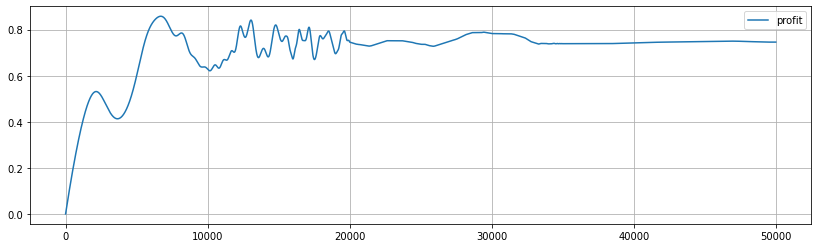

In [ ]:
pd.DataFrame({'profit':np.sum(x_history, axis=1) - np.sum(w_history, axis=1)}).plot(grid=True, figsize=(14, 4))
plt.show()

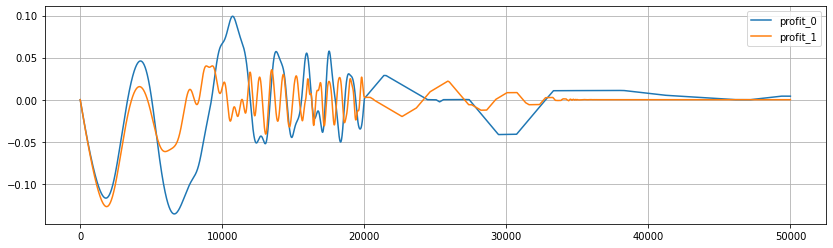

In [ ]:
(pd.DataFrame([i for i in X.apply(lambda x: [-agent_1(x.loc[0]), -agent_2(x.loc[1])], axis=1).values]) + W
 ).rename(columns={0:'profit_0', 1:'profit_1'}).plot(grid=True, figsize=(14, 4))
plt.show()

In [ ]:
print('Доход агентов')
(pd.DataFrame([i for i in X.apply(lambda x: [-agent_1(x.loc[0]), -agent_2(x.loc[1])], axis=1).values]) + W).loc[49999]

Доход агентов


0    0.004153
1   -0.000009
Name: 49999, dtype: float64

In [ ]:
print('Прибыль принципала')
pd.Series(np.sum(x_history, axis=1) - np.sum(w_history, axis=1)).loc[49999]

Прибыль принципала


0.7458538562059402

И, наконец, последняя задача.

Предположим, у производителя (принципала) нет информации, о том, какого именно типа агент, приходящий к нему, чтобы наняться на работу. Что же делать? Предлагать всем минимальную плату, за которую с нулевой для себя доходностью согласится работать тип с наихудшей производительностью (тот, у которого самая большая производная функции издержек)? А, может быть, можно добиться большей прибыли?

Действительно, это возможно, нужно добавить дополнительное условие:
$$Incentive\; compatibility\; Constraint$$
$$\forall (i, k): w_i - C_i(x_i) >= w_k - C_i(x_k)\; $$

В чем суть данного ограничения: необходимо для каждого игрока найти такие пары $(w_i, x_i)$, чтобы ни один агент не завидовал другому, не хотел притворяться другим, выбирал тот контракт $(w_i, x_i)$, который бы предназначался именно ему. Если решить данную задачу удастся, прибыль принципала будет не меньше наихудшей (той, которую он получает в случае, когда предлагает всем минимальную плату)

---
Более подробно про данную проблему можно почитать в учебнике [Микроэкономика — третий уровень, 
В. П. Бусыгин, Е. В. Желободько, А. А. Цыплаков](http://www.math.nsc.ru/~mathecon/Marakulin/For%20Students/Micro3_Book).
Если и этого кому-то покажется мало, можете обратиться к Сергею Гелиевичу

In [ ]:
def agent_1(x):
  return 0.5 * x**2
def agent_2(x):
  return x**2


class LagrangeLoss(nn.Module):
  def __init__(self, agents, mus):
    super(LagrangeLoss, self).__init__()
    self.mus = mus
    self.agents = agents
  
  def apply_cost_function(self, x):
    result = torch.zeros(x.shape)
    for i, agent in enumerate(self.agents):
      result = result + agent(x) * torch.tensor([1.0 if j==i else 0.0 for j in range(x.shape[0])])
    return result

  def calc_IR(self, x, w, z):
    result = w - self.apply_cost_function(x) - z**2
    return result
  
  def calc_IC_agent(self, x, w, lambdas, agent, i, z):
    mask = torch.tensor([1.0 if j==i else 0.0 for j in range(x.shape[0])])
    result = torch.sum((w - agent(x)) * mask) * lambdas
    result = torch.sum(result - lambdas * (w - agent(x)) - lambdas * z**2 )
    return result

  def calc_IC(self, x, w, lambdas, z):
    result = torch.tensor([0.0])
    for i, agent in enumerate(self.agents):
      result = result + self.calc_IC_agent(x, w, lambdas[i], agent, i, z[i])
    return result

  def forward(self, x, w, lambdas, z, IR_lambdas, IR_z):
    revenue = torch.sum(self.mus * (x - w))
      
    IR_const = torch.sum(lambdas[0] * self.calc_IR(x, w, z[0]))
    IC_const = self.calc_IC(x, w, IR_lambdas, IR_z)
    pos_x_const = torch.sum(lambdas[1] * (x - z[1]**2))
    pos_w_const = torch.sum(lambdas[2] * (w - z[2]**2))
    return - revenue + IR_const + IC_const + pos_x_const + pos_w_const 

In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([1e-25, 1e-25]))
        self.w = nn.Parameter(torch.tensor([1e-25, 1e-25])) 
        self.lambdas = nn.Parameter(torch.tensor([[1e-25, 1e-25] for i in range(3)]))
        self.z = nn.Parameter(torch.tensor([[1e-25, 1e-25] for i in range(3)]))
        self.IR_lambdas = nn.Parameter(torch.tensor([[1e-25, 1e-25] for i in range(2)]))       
        self.IR_z = nn.Parameter(torch.tensor([[1e-25, 1e-25] for i in range(2)]))  

    def forward(self):
        return self.x, self.w, self.lambdas, self.z, self.IR_lambdas, self.IR_z

In [ ]:
model = Model()
loss_fn = LagrangeLoss([agent_1, agent_2], torch.tensor([1/2, 1/2]))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
w_history, x_history, loss_history = [], [], []

In [ ]:
for i in range(100000):
  if i>=50000:
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
  optimizer.zero_grad()
  x, w, lambdas, z, IR_lambdas, IR_z = model()
  loss = loss_fn(x, w, lambdas, z, IR_lambdas, IR_z)
  loss_history.append(loss.item())
  x_history.append([el.item() for el in model.x.detach().numpy()])
  w_history.append([el.item() for el in model.w.detach().numpy()])
  loss.backward()

  model.lambdas.grad = - model.lambdas.grad
  model.IR_lambdas.grad = - model.IR_lambdas.grad
  optimizer.step()

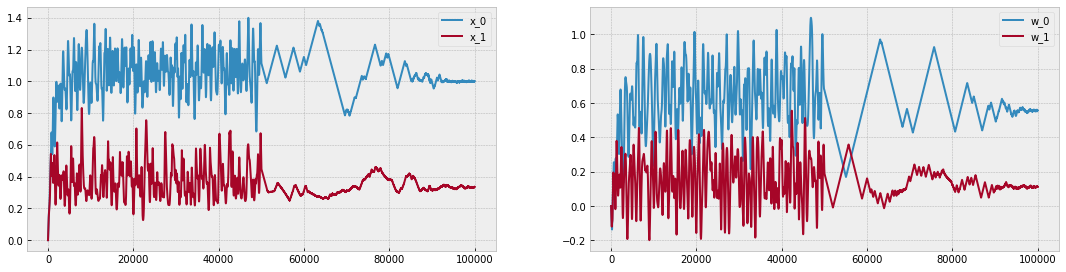

In [ ]:
X = pd.DataFrame(x_history)
W = pd.DataFrame(w_history)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18.5, 4.5)
X.rename(columns={0:'x_0', 1:'x_1'}).plot(ax=ax[0], grid=True) 
W.rename(columns={0:'w_0', 1:'w_1'}).plot(ax=ax[1], grid=True).plot(ax=ax[1], grid=True)
plt.show()

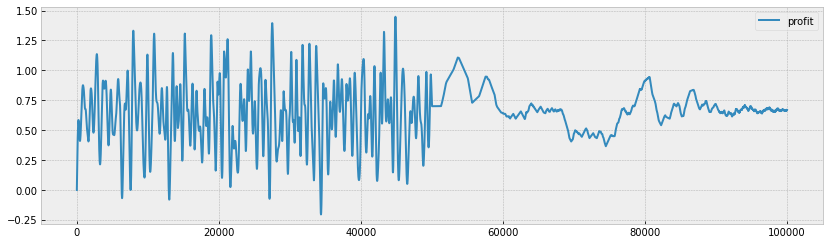

In [ ]:
pd.DataFrame({'profit':np.sum(x_history, axis=1) - np.sum(w_history, axis=1)}).plot(grid=True, figsize=(14, 4))
plt.show()

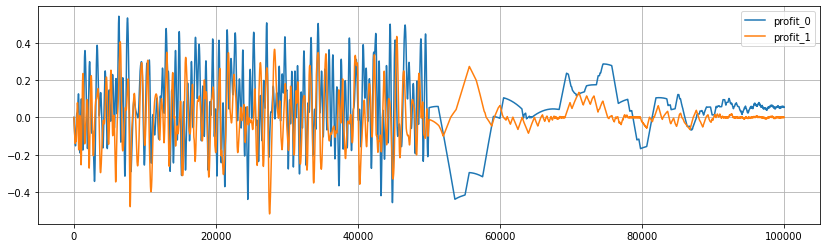

In [ ]:
(pd.DataFrame([i for i in X.apply(lambda x: [-agent_1(x.loc[0]), -agent_2(x.loc[1])], axis=1).values]) + W
 ).rename(columns={0:'profit_0', 1:'profit_1'}).plot(grid=True, figsize=(14, 4))
plt.show()

In [ ]:
print('Доход агентов')
(pd.DataFrame([i for i in X.apply(lambda x: [-agent_1(x.loc[0]), -agent_2(x.loc[1])], axis=1).values]) + W).tail(1)

Доход агентов


,0,1
99999,0.054469,-0.000282


In [ ]:
print('Прибыль принципала')
pd.Series(np.sum(x_history, axis=1) - np.sum(w_history, axis=1)).tail(1)

Прибыль принципала


99999    0.668905
dtype: float64

In [ ]:
model.x, model.w

(Parameter containing:
 tensor([1.0025, 0.3359], requires_grad=True), Parameter containing:
 tensor([0.5570, 0.1125], requires_grad=True))

Итог: данный подход позволяет решать задачи достаточно сложные.
Например в задаче скрининга (последняя) число ограничений возрастает экспоненциально числу агентов. Даже если применять различные ослабляющие допущения, такие как гипотеза Спенса-Миррлиса, с которой вы, возможно, познакомитесь на дополнительных главах микроэкономики, в худшем случае придется делать различные дополнительные действия. Здесь же процедура достаточно однообразна: как вы могли заметить, от задания к заданию меняются лишь целевые функции и структура модели.

Надеюсь что вам было интересно.

p.s. Предвосхищая возможное негодование, все вот это, или хотя бы что то аналогичное вам с нуля реализовывать не придется. Предполагаемый формат заданий приведен ниже.

p.p.s. Почему так непонятно вычисляются IC_constraints в последнем задании: PyTorch не поддерживает inplace операции, т.е. преобразования над элементами тензора (тензоры в PyTorch и Tensorflow никак не связаны с нормальными тензорами, это просто многомерные массивы, к которым можно при желании приклеить градиент), скажем tens[i] = f(tens[i]) не заработает. Так же не получится использовать генераторы списков, которые существенно упрощают написание кода, т.к. градиенты при создании тензора из нескольких тензоров попросту отбрасываются. Надо сказать, очень неприятно было все это узнавать на собственном опыте. Надеюсь, однажды эта ремарка чем нибудь вам поможет.

p.p.p.s. Естественно, будет проведена консультация, во время которой я отвечу на все вопросы, расскажу весь материал, решу с нуля одну из задачек, покажу, как нужно будет решать задания, предложенные вам.

Задание 1. 
Две задачки разной степени сложности, одна совсем простая, два-три переменные, две-три ограничения-равенства, другая посложнее -- чуть больше ограничений, переменных, часть из них -- неравенства. 
Реализовывать весь пайплайн не придется, основная структура у вас будет. Нужно будет заполнить пропуски в определении лосс-функции, классе модели, цикле обучения, проверить результаты.

In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super().__init__()
        self.x = #заполните пропуски
        self.lambdas = #заполните пропуски
        self.z = #заполните пропуски
              
        
    def forward(self):
        return #заполните пропуски

In [ ]:
class func_loss(nn.Module):
  def __init__(self):
      super(func_loss, self).__init__()
      
  def forward(self, x, lambdas):
      result = #заполните пропуски
      return result

In [ ]:
model = #заполните пропуски
loss_fn = #заполните пропуски

In [ ]:
optimizer = #заполните пропуски
objectives = []                                    
losses = []                                        
for i in range(6000):                              
  #заполните пропуски
  #заполните пропуски
  loss = loss_fn(x, lambdas)
  obj = loss_fn(model.x.detach(), torch.tensor([0.0]))
  objectives.append(obj.numpy()[0])
  losses.append(loss.item())
  #заполните пропуски
  #заполните пропуски
  optimizer.step()

Задание 2. Хотел бы чтобы вы немного вникли в скрининг, реализовывать конечно не заставлю, потому что ограничения, как вы могли заметить, записаны весьма своеобразно. Думаю, нужно будет дать экономическую интерпретацию графикам и результатам работы модели.

Какое значение у данного проекта, относительно других вариантов:

Я посмотрел про shadow prices, про интерпретацию множителей Лагранжа в экономических задачах. Вещь, безусловно, полезная, но для того чтобы получить эти самые множители Лагранжа, необходимо будет решить оптимизационную задачу. Видимо, предполагалось решать ее с помощью оптимизационных библиотек типа Gekko или Pyomo, возможно с помощью библиотеки для аналитических вычислений SymPy, как в данной статье [Optimization with constraints using Lagrange Multiplier in Python](https://towardsdatascience.com/optimization-with-constraints-using-lagrange-multiplier-in-python-82769c9a43fe). 

Мне кажется, лучше задачу условной оптимизации решать предложенным мной способом, поскольку
1. Gekko и Pyomo, конечно могут быть весьма практически полезными, но они решают оптимизационные задачи множеством способов, что с точки зрения обучения является скорее недостатком: студенты просто физически не смогут успеть получить представление, о том как, хотя бы какая то часть из этих методов работает, в чем их плюсы и недостатки. Подход же, который предлагаю я, является интуитивно понятным, и студенты смогут успешно осознать весь процесс решения задачи от начала и до конца
2. Минус подхода с использованием SymPy состоит в том, что он является не гибким и не масштабируемым. Когда мы используем SymPy мы находим решение аналитически, просто перекладываем вычисление производных и решение СЛАУ на компъютер. Это не оптимально по двум причинам:
  1. Во первых, для решения задачи от нас потребуется записать весь лагранжиан в виде функции, размер которой для задачи скрининга, где число ограничений возрастает экспоненциально, наверное будет поражать воображение. Легко представить ситуацию, что где-то в середине мы опечатались, звучит неприятно. Можно конечно реализовать класс, который бы автоматически создавал Лагранжиан из некоторых переданных аргументов, но нам это и так пришлось сделать.
  2. Аналитический метод Лагранжа не работает в случае ограничений, выраженных неравенствами.

При желании, можно включить задачку на экономическую интерпретацию множителей Лагранжа, алгоритм градиентной оптимизации их тоже находит.
